In [11]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import statsmodels.api as sm

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [13]:
file_id = 'https://docs.google.com/spreadsheets/d/1TfEy6WxL-JB2IMUVAClbqwNIddNv-GVl/edit?usp=sharing&ouid=113544346438304110369&rtpof=true&sd=true'  # Replace with your actual file ID
file_path = f'/content/gdrive/MyDrive/Finance project Python/dollar index spot currency.xlsx'  # Replace with your actual file ID


df = pd.read_excel(file_path)

In [14]:
from statsmodels.tsa.arima.model import ARIMA

# Assuming the time series column is named 'data'
time_series = df['Last Price']

# Fit ARMA model
model = ARIMA(time_series, order=(2, 1, 2))
model_fit = model.fit()

# Print the summary of the model
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             Last Price   No. Observations:                 2740
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -1461.116
Date:                Sun, 25 Jun 2023   AIC                           2932.233
Time:                        19:45:51   BIC                           2961.809
Sample:                             0   HQIC                          2942.921
                               - 2740                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0013     12.330      0.000      1.000     -24.164      24.167
ar.L2         -0.0010      7.115     -0.000      1.000     -13.947      13.945
ma.L1          0.0013     12.330      0.000      1.0

In [15]:
# Generate predictions
predictions = model_fit.predict()


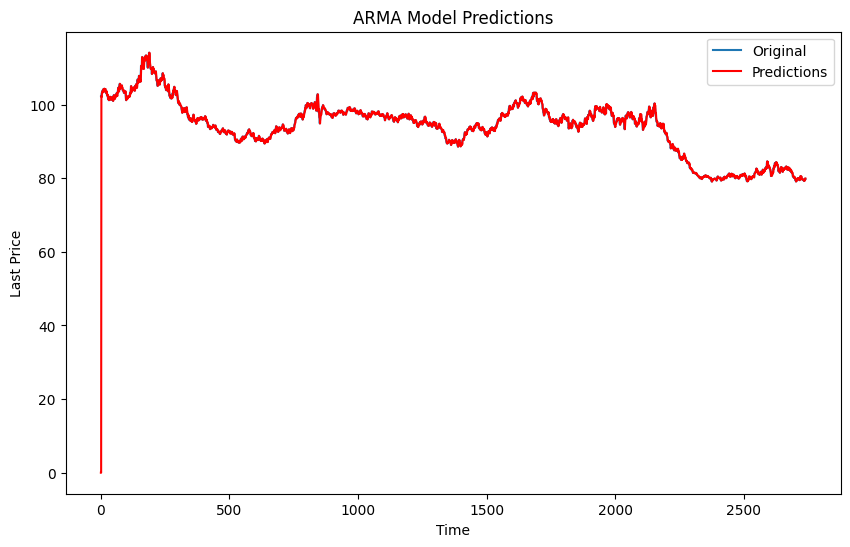

In [16]:
# Remove missing values and NaNs
time_series_clean = time_series.dropna()
# Plot the figure
plt.figure(figsize=(10, 6))
plt.plot(time_series_clean, label='Original')
plt.plot(predictions, color='red', label='Predictions')
plt.title('ARMA Model Predictions')
plt.xlabel('Time')
plt.ylabel('Last Price')
plt.legend()
plt.show()


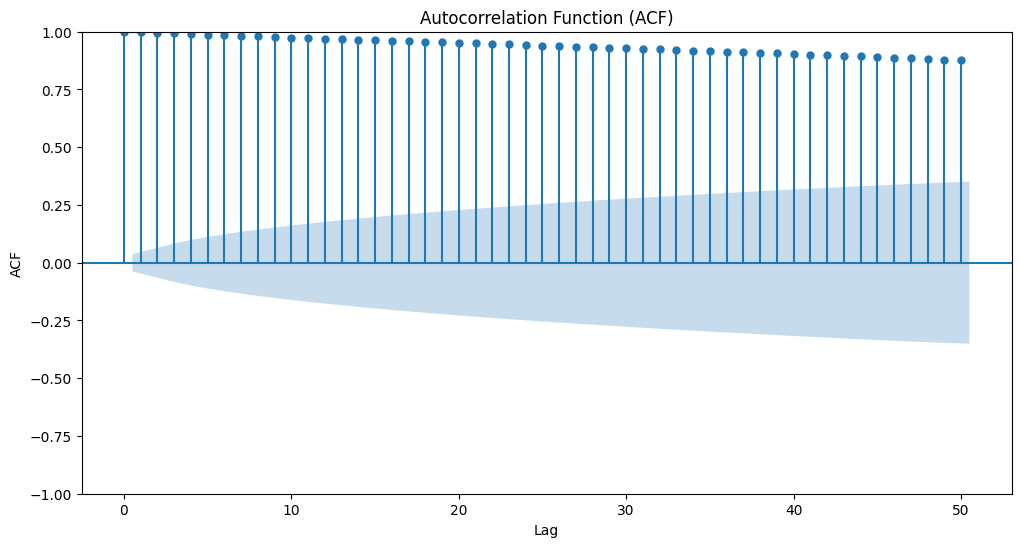

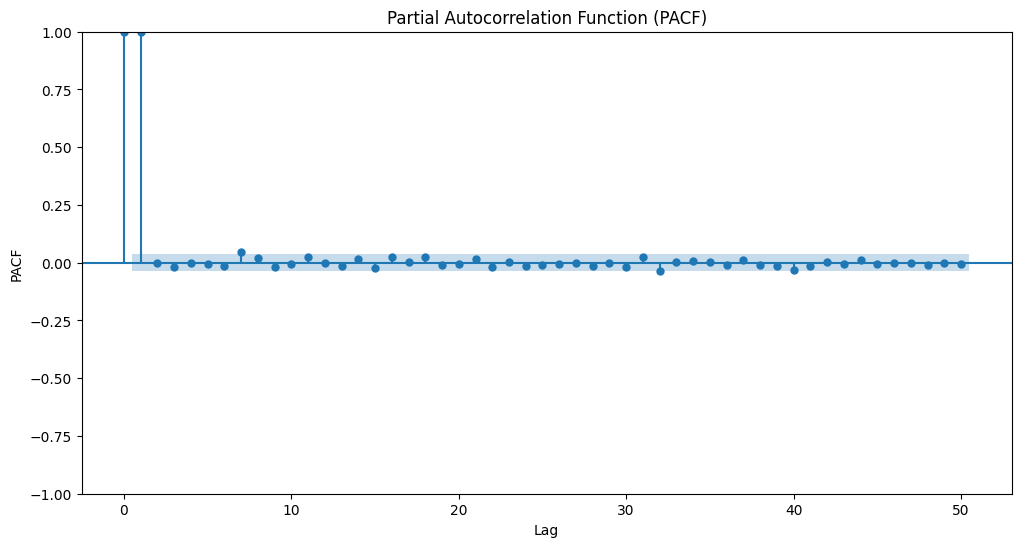

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(time_series_clean, lags=50, ax=ax)
ax.set(title='Autocorrelation Function (ACF)', xlabel='Lag', ylabel='ACF')
plt.show()

# Plot PACF
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(time_series_clean, lags=50, ax=ax)
ax.set(title='Partial Autocorrelation Function (PACF)', xlabel='Lag', ylabel='PACF')
plt.show()


In [18]:


# Perform ADF test on the cleaned time series
result = adfuller(time_series_clean)

# Extract and print ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'    {key}: {value}')


ADF Statistic: -1.0493752063996695
p-value: 0.7348328267904379
Critical Values:
    1%: -3.43274059216515
    5%: -2.8625961912802333
    10%: -2.567332244679086


From the ADF test results, we can interpret the following:

ADF Statistic: -1.0493752063996695

The ADF statistic is a negative value, indicating that the time series is stationary to some extent. However, the magnitude of the statistic is relatively small.
p-value: 0.7348328267904379

The p-value is greater than the significance level of 0.05. This suggests that we cannot reject the null hypothesis of the ADF test, which states that the time series is non-stationary. The high p-value indicates that the time series may contain a unit root and is non-stationary.
Critical Values:

The critical values at different significance levels (1%, 5%, and 10%) are provided for comparison with the ADF statistic. If the ADF statistic is more negative (smaller in magnitude) than these critical values, it provides stronger evidence in favor of stationarity. In this case, the ADF statistic does not exceed the critical values significantly.
Based on these results, we can infer that the time series is likely non-stationary and may contain a unit root. Further analysis or transformation may be required to achieve stationarity in the data.

**Detrending**

In [19]:
# Define the window size for the moving average
window_size = 2

# Apply moving average smoothing to the time series
smoothed_series = time_series_clean.rolling(window=window_size).mean()

# Print the smoothed series
print(smoothed_series)

1            NaN
2       102.1790
3       102.5315
4       103.1430
5       103.4960
          ...   
2735     79.3140
2736     79.4635
2737     79.5740
2738     79.7540
2739     79.8715
Name: Last Price, Length: 2739, dtype: float64


In [20]:
# Drop any rows with missing values
smoothed_series_cleaned = smoothed_series.dropna()

# Perform ADF test
result = adfuller(smoothed_series_cleaned)

# Extract and print ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'    {key}: {value}')

ADF Statistic: -0.9566843851892121
p-value: 0.768733184939195
Critical Values:
    1%: -3.43276353256931
    5%: -2.8626063225123146
    10%: -2.5673376385571394


**Akaike’s Information Criterion (AIC)**\
This criterion is useful for selecting the order (p,d,q) of an ARIMA model. The AIC is expressed as:
AIC=-2log(L)+2k
Where L is the likelihood of the data and k is the number of parameters.

In practice, we select the model with the lowest AIC compared to other models.

It is important to note that the AIC cannot be used to select the order of differencing (d). Differencing the data will the change the likelihood (L) of the data. The AIC of models with different orders of differencing are therefore not comparable.

Also, notice that since we select the model with the lowest AIC, more parameters will increase the AIC score and thus penalize the model. While a model with more parameters could perform better, the AIC is used to find the model with the least number of parameters that will still give good results.

A final note on AIC is that it can only be used relative to other models. A small AIC value is not a guarantee that the model will have a good performance on unsee data, or that its SSE will be small.

**Log differencing**

In [21]:
# Assuming your time series is stored in the variable 'time_series'
log_diff_time_series = np.log(time_series).diff()

# Drop the first NaN value resulting from the differencing
log_diff_time_series = log_diff_time_series.dropna()

In [22]:
# Assuming you have the log-differenced time series stored in the variable 'log_diff_time_series'
result = adfuller(log_diff_time_series)

# Extract and print ADF test results
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]

print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
print('Critical Values:')
for key, value in critical_values.items():
    print(f'    {key}: {value}')

ADF Statistic: -21.24440353107157
p-value: 0.0
Critical Values:
    1%: -3.4327467254180486
    5%: -2.8625988999327463
    10%: -2.567333686767106


Based on the ADF (Augmented Dickey-Fuller) test results, we can infer the following:

ADF Statistic: The ADF statistic value is -21.24440353107157. This value is significantly lower than the critical values at the 1%, 5%, and 10% levels. It indicates strong evidence against the null hypothesis of non-stationarity. A more negative ADF statistic suggests a stronger rejection of the null hypothesis.

p-value: The p-value is 0.0, which is less than the significance level of 0.05. This indicates strong evidence against the null hypothesis and suggests that the time series is stationary.

Critical Values: The critical values at the 1%, 5%, and 10% levels are -3.4327467254180486, -2.8625988999327463, and -2.567333686767106, respectively. Since the ADF statistic is lower than all of these critical values, it further supports the inference of stationarity.

In summary, based on the ADF test results, we can conclude that the log-differenced time series is stationary.

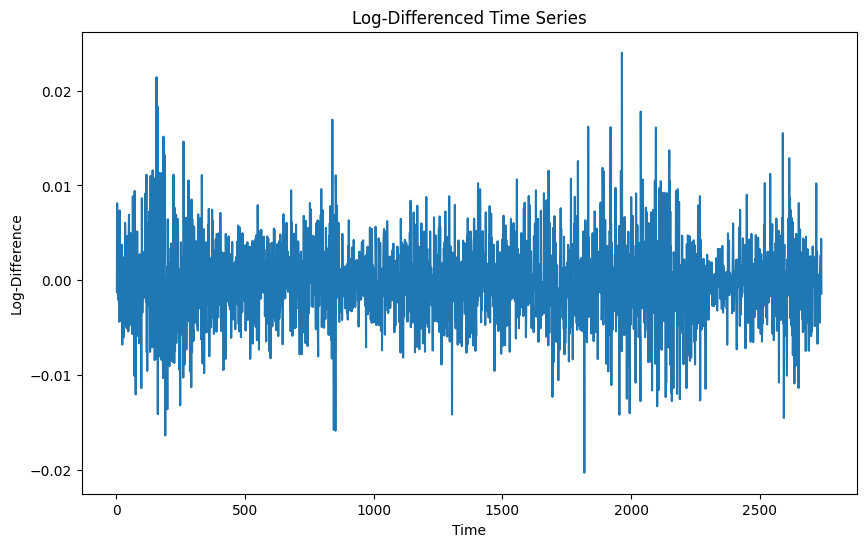

In [23]:
# Assuming you have the log-differenced time series stored in the variable 'log_diff_time_series'
plt.figure(figsize=(10, 6))
plt.plot(log_diff_time_series)
plt.title('Log-Differenced Time Series')
plt.xlabel('Time')
plt.ylabel('Log-Difference')
plt.show()

In [26]:
import pandas as pd
from itertools import product
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX

ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)

# Create a list with all possible combinations of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, d)
    each = tuple(each)
    order_list.append(each)

# Replace 'data' with your actual dataset or DataFrame
my_dataset = pd.read_excel('/content/gdrive/MyDrive/Finance project Python/dollar index spot currency.xlsx')  # Example: Read from an Excel file

# Extract the exogenous variable column
exog_variable = my_dataset['Last Price']

def optimize_ARIMA(order_list, exog):
    results = []

    for order in tqdm(order_list):
        try:
            model = SARIMAX(time_series, exog=exog, order=order).fit(disp=-1)
            results.append((order, model.aic))
        except:
            continue

    result_df = pd.DataFrame(results, columns=['Order', 'AIC']).sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

# Call the function with the order_list and exog_variable
result_df = optimize_ARIMA(order_list, exog_variable)

# Display the result
print(result_df)


100%|██████████| 64/64 [00:00<00:00, 3107.40it/s]

Empty DataFrame
Columns: [Order, AIC]
Index: []


If the output is showing an empty DataFrame, it means that none of the attempted SARIMAX models could be fitted successfully. This could be due to various reasons such as the data not meeting the assumptions of the model, convergence issues, or inadequate amount of data.

Here are a few suggestions to troubleshoot the issue:

1. Ensure that the `time_series` variable used in the `SARIMAX` model is defined and contains the appropriate time series data.
2. Check if the `exog_variable` contains valid exogenous variable data and is aligned with the `time_series`.
3. Verify that the dataset used for modeling has sufficient data points to estimate the SARIMAX models. In some cases, the dataset may be too small to fit complex models, leading to empty results.
4. Consider exploring different combinations of `ps`, `d`, and `qs` values or expanding the range to cover a wider parameter space.
5. Check if there are any warnings or error messages during the model fitting process. These can provide insights into potential issues with the data or model specification.

It's important to note that SARIMAX models require careful consideration of data properties and appropriate model selection. If the issue persists, you may need to further investigate the data and modeling approach to find a suitable solution.